In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import gc
import os 
import fpfs
import galsim
import numpy as np
import matplotlib.pylab as plt
from astropy.visualization import simple_norm
from mpl_toolkits.axes_grid1 import ImageGrid

import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2.0 #set the value globally

# README
This notebook show the test on isolated galaxies (center known)

2023/03/05 03:46:54 ---  Processing for g1-2222, and shears for four redshift bins are [0.02 0.02 0.02 0.02].


Making Basic Simulation. ID: 2


0

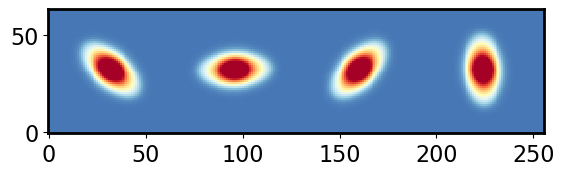

In [9]:
shear_value = 0.02
scale = 0.168
outDir='galaxy_basicCenter_psf60'
psfInt = galsim.Moffat(
    beta=3.5, fwhm=0.6, trunc=0.6 * 4.0
).shear(e1=0.02, e2=-0.02)
psfData = psfInt.shift(0.5 * scale, 0.5 * scale).drawImage(nx=64, ny=64, scale=scale).array

# Four Galaxies to cancel spin-2 and spin-4 ansiotropies
# spin-2 is shape noise in diagnonal elements of shear response matrix
# spin-4 is shape noise in diagnonal and of-diagnoal elements of shear response matrix, 
# but an order of magnitude smaller than spin-2
gal_data = fpfs.simutil.make_basic_sim(
    outDir,psf_obj=psfInt,gname='g1-2222',
    ind0=2,ny=64,nx=256, scale=scale,
    do_write=False,return_array=True,
    shear_value = shear_value)
plt.close()
plt.imshow(gal_data,aspect='equal',cmap='RdYlBu_r',origin='lower',interpolation='None',\
             norm=simple_norm(gal_data,'asinh',asinh_a=0.1,min_cut=-0.01,max_cut=0.3))
gc.collect()

In [10]:
# Now we measure shear
rcut = 32

# fake detection
indX = np.arange(32, 256, 64)
indY = np.arange(32, 64, 64)
inds = np.meshgrid(indY, indX, indexing="ij")
coords = np.array(
    np.zeros(inds[0].size),
    dtype=[("fpfs_y", "i4"), ("fpfs_x", "i4")],
)
coords["fpfs_y"] = np.ravel(inds[0])
coords["fpfs_x"] = np.ravel(inds[1])
imgList = [
    gal_data[
        cc["fpfs_y"] - rcut : cc["fpfs_y"] + rcut,
        cc["fpfs_x"] - rcut : cc["fpfs_x"] + rcut,
    ]
    for cc in coords
]


In [11]:
fpTask  =   fpfs.image.measure_source(psfData, sigma_arcsec=0.7)
mms =  fpTask.measure(imgList)
ells=   fpfs.catalog.fpfs_m2e(mms,const=2000,noirev=False)
resp=np.average(ells['fpfs_R1E'])
shear=np.average(ells['fpfs_e1'])/resp

2023/03/05 03:46:57 ---  Gaussian kernel in configuration space: sigma= 0.7000 arcsec


In [14]:
print('Input shear is: %.6f' %shear_value)
print('Estimated shear is: %.6f' %shear)

Input shear is: 0.020000
Estimated shear is: 0.020001
